In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split, col, avg, count, round
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [21]:
spark = SparkSession.builder.appName("YelpDataAnalysis").getOrCreate()

In [22]:
yelp_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_business.json")

arizona_df = yelp_df.filter(yelp_df["state"] == "AZ")
nightlife_df = arizona_df.filter(arizona_df["categories"].contains("Nightlife"))
nightlife_df.createOrReplaceTempView("nightlife")

In [23]:
# Read the check-in data
checkin_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_checkin.json")
checkin_df.createOrReplaceTempView("checkin")

In [24]:
# Read the review data
review_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_review.json")
review_df.createOrReplaceTempView("review")

1. Top Rated Nightlife Businesses
Finds the top 10 Nightlife businesses in Arizona with the highest average star ratings, adding the number of reviews column. Sorts them based on the number of ratings received by the business.

In [25]:
# Spark SQL query
top_nightlife_businesses = spark.sql("""
SELECT name, stars, review_count
FROM nightlife
ORDER BY stars DESC, review_count DESC
LIMIT 10
""")

# Show the results
top_nightlife_businesses.show()

+--------------------+-----+------------+
|                name|stars|review_count|
+--------------------+-----+------------+
|  The Blacktop Grill|  5.0|          99|
|Splitting Timber ...|  5.0|          79|
|   Unscrewed Theater|  5.0|          72|
|Arizona Party Bik...|  5.0|          50|
|         Louie's Pub|  5.0|          27|
|    Portal Cocktails|  5.0|          19|
|      Medusas On 4th|  5.0|          12|
|  Old Pueblo Cellars|  5.0|          12|
|Tony G DJ and Kar...|  5.0|          11|
|Campbell Avenue B...|  5.0|          10|
+--------------------+-----+------------+



VISUALISATION FOR QUERY 1

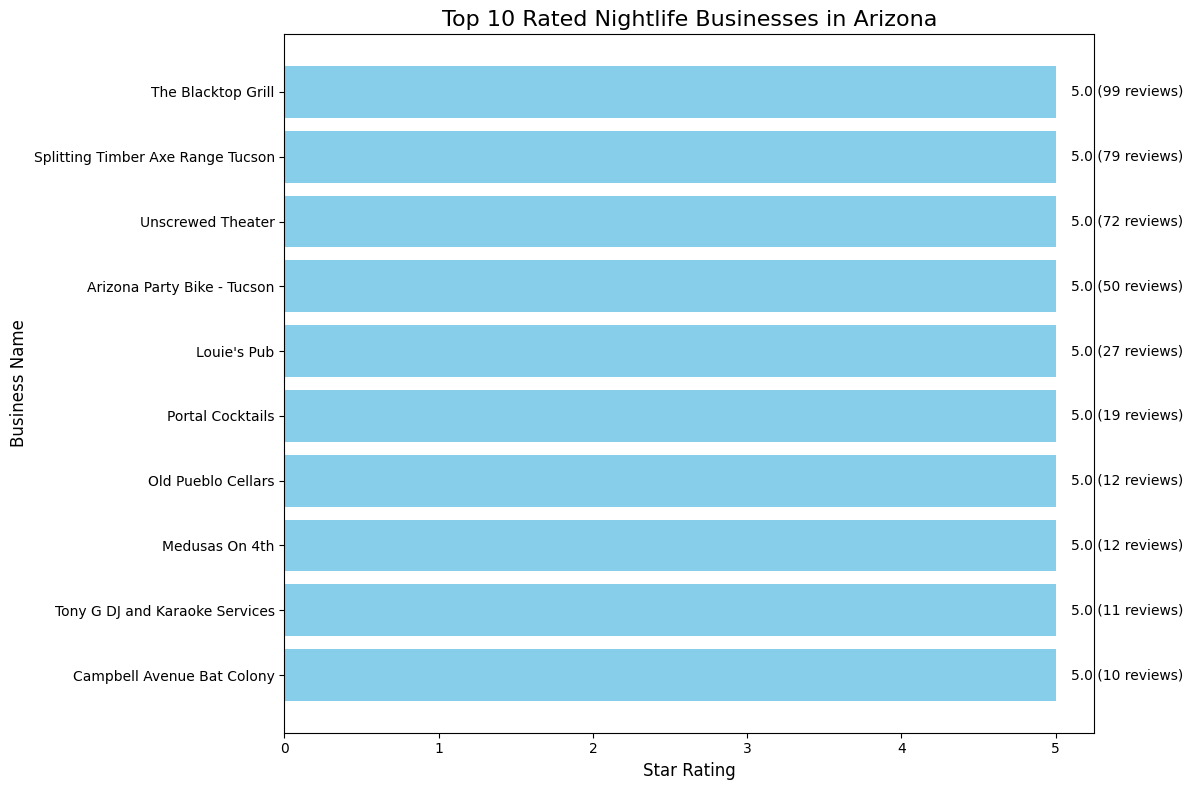

In [26]:
# Convert Spark SQL results to Pandas DataFrame
top_nightlife_businesses_df = top_nightlife_businesses.toPandas()

# Sort the DataFrame by star ratings and review count
top_nightlife_businesses_df = top_nightlife_businesses_df.sort_values(by=["stars", "review_count"], ascending=[True, True])

# Create the bar chart
plt.figure(figsize=(12, 8))
bars = plt.barh(
    top_nightlife_businesses_df["name"],
    top_nightlife_businesses_df["stars"],
    color="skyblue"
)

# Add labels and title
plt.title("Top 10 Rated Nightlife Businesses in Arizona", fontsize=16)
plt.xlabel("Star Rating", fontsize=12)
plt.ylabel("Business Name", fontsize=12)

# Annotate bars with review count
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height() / 2, f"{width:.1f} ({top_nightlife_businesses_df.iloc[bars.index(bar), 2]} reviews)", va="center", fontsize=10)

# Show the chart
plt.tight_layout()
plt.show()

QUERY 2 - List of Cities with Best Nightlife Scene

In [27]:
# Spark SQL query
best_nightlife_cities = spark.sql("""
SELECT city,
       ROUND(AVG(stars), 2) AS avg_stars,
       SUM(review_count) AS total_reviews,
       COUNT(*) AS num_businesses
FROM nightlife
GROUP BY city
HAVING COUNT(*) > 1 
ORDER BY avg_stars DESC, total_reviews DESC
LIMIT 5
""")

# Show the results
best_nightlife_cities.show()

+------------+---------+-------------+--------------+
|        city|avg_stars|total_reviews|num_businesses|
+------------+---------+-------------+--------------+
|  Oro Valley|     3.71|         2240|            14|
|      Tucson|     3.62|        71259|           516|
|      Marana|     3.42|          357|             6|
|        Vail|     3.25|          270|             4|
|Green Valley|     2.75|           50|             2|
+------------+---------+-------------+--------------+



VISUALIZATION FOR QUERY 2

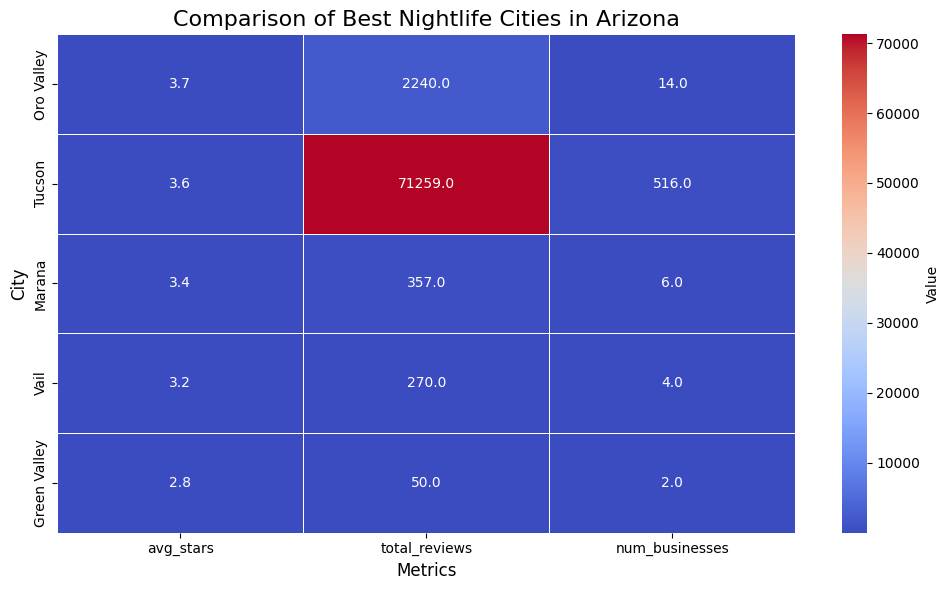

In [28]:
# Convert Spark SQL results to Pandas DataFrame
best_nightlife_cities_df = best_nightlife_cities.toPandas()

# Prepare the data for a heat map (pivot to display metrics for each city)
heatmap_data = best_nightlife_cities_df.set_index("city")[["avg_stars", "total_reviews", "num_businesses"]]

# Create the heat map
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={"label": "Value"}
)

# Add labels and title
plt.title("Comparison of Best Nightlife Cities in Arizona", fontsize=16)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("City", fontsize=12)

# Show the heat map
plt.tight_layout()
plt.show()

3. Peak Check-in Days
Determine which days of the week Nightlife businesses receive the most check-ins.

In [29]:
# Spark SQL query using JOIN
peak_checkin_days = spark.sql("""
WITH exploded_checkins AS (
    SELECT n.business_id,
           explode(split(c.date, ', ')) AS checkin_time
    FROM nightlife n
    JOIN checkin c ON n.business_id = c.business_id
),
formatted_checkins AS (
    SELECT business_id,
           date_format(to_timestamp(checkin_time, 'yyyy-MM-dd HH:mm:ss'), 'E') AS day_of_week
    FROM exploded_checkins
    WHERE checkin_time IS NOT NULL AND checkin_time != ''
)
SELECT day_of_week,
       COUNT(*) AS num_checkins
FROM formatted_checkins
GROUP BY day_of_week
ORDER BY num_checkins DESC
""")

# Show the results
peak_checkin_days.show()

+-----------+------------+
|day_of_week|num_checkins|
+-----------+------------+
|        Sat|       40467|
|        Sun|       39638|
|        Fri|       23411|
|        Thu|       18373|
|        Wed|       17150|
|        Mon|       16089|
|        Tue|       15188|
+-----------+------------+



Visualization for Query 3

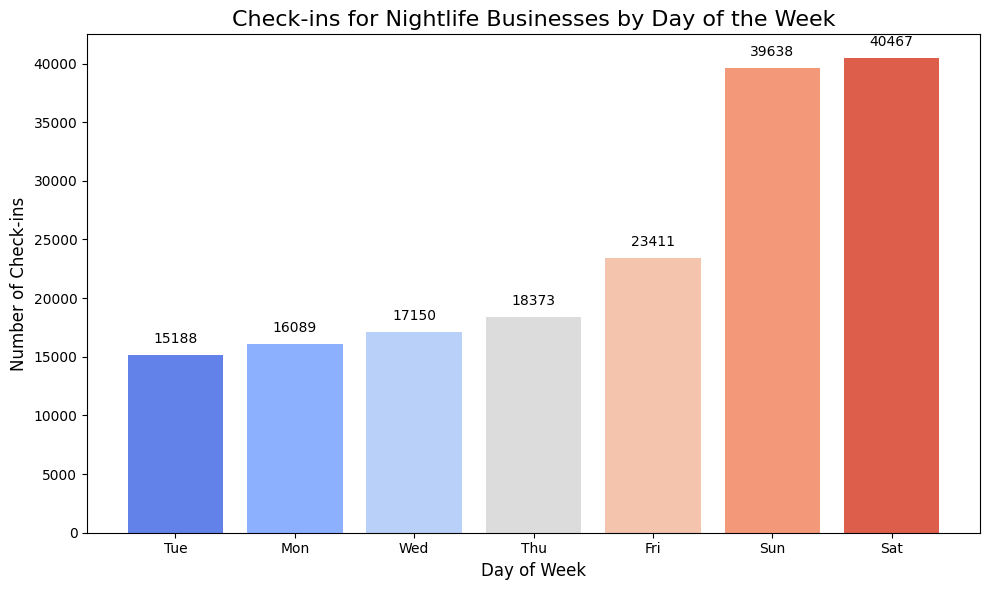

In [30]:
peak_checkin_days_df = peak_checkin_days.toPandas()
peak_checkin_days_df = peak_checkin_days_df.sort_values(by="num_checkins", ascending=True)

palette = sns.color_palette("coolwarm", len(peak_checkin_days_df))

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(
    peak_checkin_days_df["day_of_week"], 
    peak_checkin_days_df["num_checkins"], 
    color=palette
)

# Add labels and title
plt.title("Check-ins for Nightlife Businesses by Day of the Week", fontsize=16)
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("Number of Check-ins", fontsize=12)

# Annotate bars with exact values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1000, int(yval), ha="center", fontsize=10)

# Show the chart
plt.tight_layout()
plt.show()

QUERY 4: Check-in Counts and Business Success

In [31]:
exploded_checkins_df = checkin_df.select(
    "business_id",
    explode(split(checkin_df["date"], ", ")).alias("checkin_time")
)
exploded_checkins_df.createOrReplaceTempView("exploded_checkins")


In [32]:
checkins_business_success = spark.sql("""
WITH total_checkins AS (
    SELECT business_id, COUNT(*) AS total_checkins
    FROM exploded_checkins
    GROUP BY business_id
)
SELECT COALESCE(tc.total_checkins, 0) AS total_checkins,
       ROUND(AVG(n.stars), 2) AS avg_stars,
       ROUND(AVG(n.review_count), 2) AS avg_review_count,
       COUNT(*) AS num_businesses
FROM nightlife n
LEFT JOIN total_checkins tc ON n.business_id = tc.business_id
GROUP BY total_checkins
ORDER BY total_checkins DESC
""")

# Show the results
checkins_business_success.show()

+--------------+---------+----------------+--------------+
|total_checkins|avg_stars|avg_review_count|num_businesses|
+--------------+---------+----------------+--------------+
|          4487|      4.0|          1270.0|             1|
|          3245|      4.5|          2126.0|             1|
|          3081|      4.5|           805.0|             1|
|          2827|      3.5|           916.0|             1|
|          2575|      4.0|           394.0|             1|
|          2507|      3.5|           414.0|             1|
|          2421|      4.0|           611.0|             1|
|          2355|      3.5|           333.0|             1|
|          2282|      4.0|           862.0|             1|
|          2192|      4.0|           571.0|             1|
|          2069|      3.5|          1583.0|             1|
|          1962|      4.0|          1117.0|             1|
|          1942|      4.0|           378.0|             1|
|          1901|      4.0|           662.0|             

VISUALIZATION FOR QUERY 4

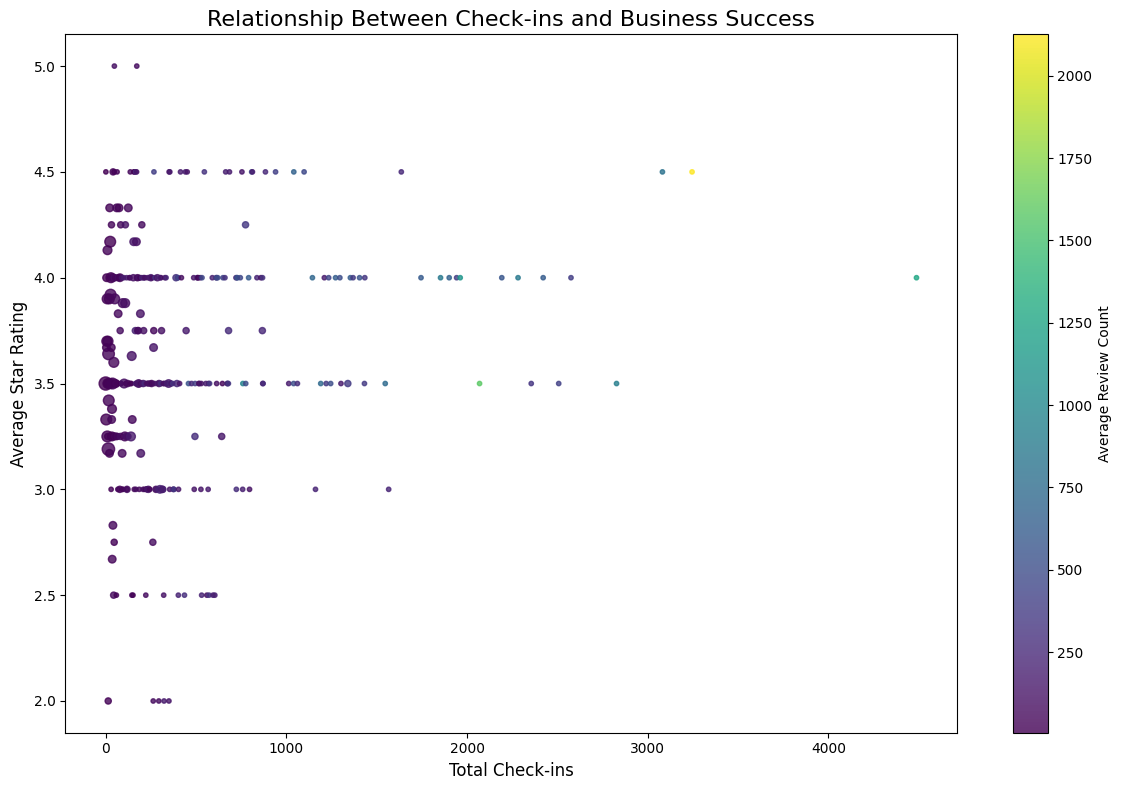

In [33]:
# Convert the Spark SQL results to a Pandas DataFrame
checkins_business_success_df = checkins_business_success.toPandas()

# Sort by total_checkins for consistent coloring
checkins_business_success_df = checkins_business_success_df.sort_values(by="total_checkins")

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    checkins_business_success_df["total_checkins"],
    checkins_business_success_df["avg_stars"],
    c=checkins_business_success_df["avg_review_count"],
    cmap="viridis",
    s=checkins_business_success_df["num_businesses"] * 10,  # Size based on the number of businesses
    alpha=0.8
)

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label("Average Review Count")

# Add labels and title
plt.title("Relationship Between Check-ins and Business Success", fontsize=16)
plt.xlabel("Total Check-ins", fontsize=12)
plt.ylabel("Average Star Rating", fontsize=12)

# Show the chart
plt.tight_layout()
plt.show()

QUERY 5 - High-Rating Postal Codes


In [34]:
nightlife_df = nightlife_df.filter(
    (col("postal_code").isNotNull()) & (col("postal_code") != "") &
    (col("city").isNotNull()) & (col("city") != "")
)

In [35]:
# Create a temporary view
nightlife_df.createOrReplaceTempView("nightlife")

In [36]:
# Spark SQL query using JOIN
high_rating_postal_codes = spark.sql("""
SELECT n.postal_code,
       n.city,
       ROUND(AVG(r.stars), 2) AS avg_stars,
       COUNT(DISTINCT n.business_id) AS num_businesses,
       COUNT(r.review_id) AS num_reviews
FROM nightlife n
JOIN review r ON n.business_id = r.business_id
GROUP BY n.postal_code, n.city
HAVING COUNT(r.review_id) >= 5  -- Consider postal codes with at least 5 reviews
ORDER BY avg_stars DESC, num_reviews DESC
LIMIT 10
""")

# Show the results
high_rating_postal_codes.show()

+-----------+---------------+---------+--------------+-----------+
|postal_code|           city|avg_stars|num_businesses|num_reviews|
+-----------+---------------+---------+--------------+-----------+
|      85721|         Tucson|     4.92|             1|         12|
|      85742|         Tucson|     4.84|             2|         92|
|      85701|Tucson, Arizona|     4.44|             1|          9|
|      85739|         Tucson|     4.04|             3|         84|
|      85745|         Tucson|     4.01|            13|       2410|
|      85704|     Oro Valley|     3.99|             2|        181|
|      85712|         Tucson|     3.92|            34|       3809|
|      85701|         Tucson|     3.91|            66|      15044|
|      85719|         Tucson|     3.89|            54|      11158|
|      85750|         Tucson|     3.87|            10|       1409|
+-----------+---------------+---------+--------------+-----------+



VISUALIZATION FOR QUERY 5

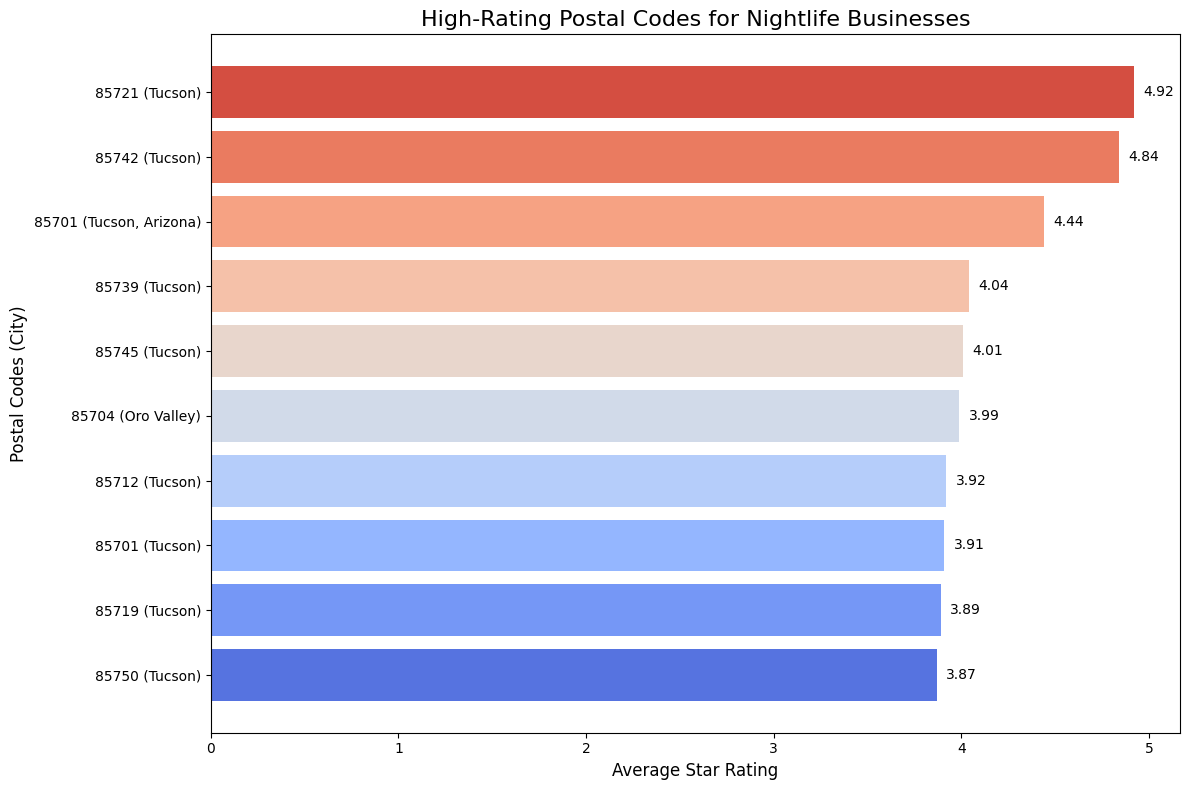

In [37]:
# Convert the Spark SQL results to a Pandas DataFrame
high_rating_postal_codes_df = high_rating_postal_codes.toPandas()

# Sort the DataFrame by average star ratings and number of reviews
high_rating_postal_codes_df = high_rating_postal_codes_df.sort_values(
    by=["avg_stars", "num_reviews"], ascending=[True, True]
)

# Set a color palette based on average star ratings
palette = sns.color_palette("coolwarm", len(high_rating_postal_codes_df))

# Create the horizontal bar chart
plt.figure(figsize=(12, 8))
bars = plt.barh(
    high_rating_postal_codes_df["postal_code"].astype(str) + " (" + high_rating_postal_codes_df["city"] + ")",
    high_rating_postal_codes_df["avg_stars"],
    color=palette
)

# Add labels and title
plt.title("High-Rating Postal Codes for Nightlife Businesses", fontsize=16)
plt.xlabel("Average Star Rating", fontsize=12)
plt.ylabel("Postal Codes (City)", fontsize=12)

# Annotate bars with average star ratings
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.05, bar.get_y() + bar.get_height() / 2, f"{width:.2f}", va="center", fontsize=10)

# Show the chart
plt.tight_layout()
plt.show()